In [193]:
import argparse
import os
import time

import numpy as np
from jax.nn import sigmoid

import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro.diagnostics import summary
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import matplotlib.pyplot as plt

In [194]:
def binary_model(X, Y):
    D = X.shape[1]

    lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(D)))
    tau = numpyro.sample("tau", dist.HalfCauchy(jnp.ones(1)))

    unscaled_betas = numpyro.sample("unscaled_betas", dist.Normal(0, jnp.ones(D)))
    scaled_betas = numpyro.deterministic("betas", tau*lambdas*unscaled_betas)

    mean_function = X @ scaled_betas

    numpyro.sample("Y", dist.Bernoulli(logits=mean_function), obs=Y)

In [195]:
def run_inference(model, rng_key, X, Y):
    nuts = NUTS(model)
    mcmc = MCMC(
        nuts,
        num_warmup=500,
        num_samples=1000,
        num_chains=4,
        progress_bar=False
    )
    mcmc.run(rng_key, X, Y)
    # mcmc.print_summary(exclude_deterministic=True)

    samples = mcmc.get_samples()
    summary_dict = summary(samples, group_by_chain=False)
    return summary_dict

In [196]:
def get_data(N, D, sigma):
    X = np.random.randn(N, D)
    W = np.array([2, -1, 0.5])
    Y = jnp.dot(X[:, :3], W)
    Y -= jnp.mean(Y)
    Y = np.random.binomial(1, sigmoid(Y))
    return X, Y


In [197]:
N, D = 50, 10
X, Y = get_data(N=N, D=D, sigma=1)
rng_key, rng_key_ = random.split(random.PRNGKey(0))
summary = run_inference(binary_model, rng_key, X, Y)
    
    

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_78789/2237750593.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


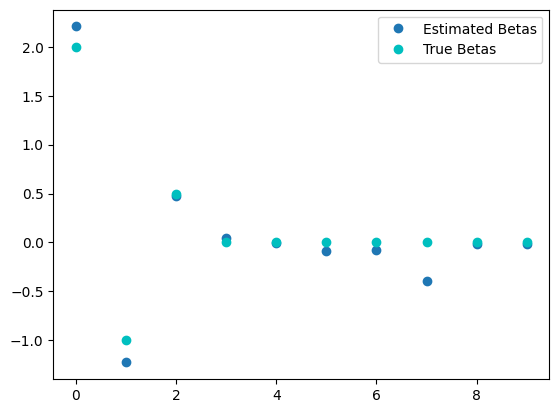

In [211]:
betas = summary['betas']['mean']
print()

plt.plot(betas, 'o', label="Estimated Betas")

true_betas = np.zeros(D)

true_betas[:3] = [2, -1, 0.5]

plt.plot(true_betas, 'co', label="True Betas")
plt.legend()